In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets
from keras.models import Sequential
from keras.applications.mobilenet import MobileNet
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback

#!pip install -U efficientnet
from keras import layers
from keras import regularizers 

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory


import seaborn as sn
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical 

In [4]:
from tqdm import tqdm
import os
from PIL import Image
import cv2

In [5]:
# Some constant
BATCH_SIZE = 32
IMG_SIZE = 224
LABEL_MODE = "categorical"
MODEL_NAME = "mobilenet_b0_v1"

In [6]:
labels = ["Begnin", "Maligne"]
NB_CLASS = len(labels)
labels

['Begnin', 'Maligne']

In [7]:
def Dataset_loader(DIR, RESIZE):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".BMP":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            IMG.append(np.array(img)/255.)
    return IMG

In [8]:
#benign_train = np.array(Dataset_loader("../data/preprocessed/img/Train/Begnin/",IMG_SIZE))
#malign_train = np.array(Dataset_loader("../data/preprocessed/img/Train/Maligne/",IMG_SIZE))
benign_val = np.array(Dataset_loader("../data/preprocessed/img/Validation/Begnin/",IMG_SIZE))
malign_val = np.array(Dataset_loader("../data/preprocessed/img/Validation/Maligne/",IMG_SIZE))
benign_test = np.array(Dataset_loader("../data/preprocessed/img/Test/Begnin/",IMG_SIZE))
malign_test = np.array(Dataset_loader("../data/preprocessed/img/Test/Maligne/",IMG_SIZE))

100%|██████████| 503/503 [00:02<00:00, 222.00it/s]


In [9]:
## Create labels
#benign_train_label = np.zeros(len(benign_train))
#malign_train_label = np.ones(len(malign_train))
benign_val_label = np.zeros(len(benign_val))
malign_val_label = np.ones(len(malign_val))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))
#
## Merge data 
#X_train = np.concatenate((benign_train, malign_train), axis = 0)
#y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_val = np.concatenate((benign_val, malign_val), axis = 0)
y_val = np.concatenate((benign_val_label, malign_val_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)
#
## Shuffle train data
#s = np.arange(X_train.shape[0])
#np.random.shuffle(s)
#X_train = X_train[s]
#y_train = y_train[s]
#
## Shuffle validation data
s = np.arange(X_val.shape[0])
np.random.shuffle(s)
X_val = X_val[s]
y_val = y_val[s]
#
## Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]
#
## one hot encoding 
#y_train = to_categorical(y_train, num_classes=NB_CLASS)
y_test = to_categorical(y_test, num_classes=NB_CLASS)
y_val = to_categorical(y_val, num_classes=NB_CLASS)

In [10]:
# data augmentation - cut out 
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [11]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,  # randomly flip images
    preprocessing_function=get_random_eraser(p=0.5, v_h=0, s_h=0.25),
    rescale=1./255)

In [14]:
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model=Sequential()
model.add(mobilenet)
model.add(layers.GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(NB_CLASS, activation='softmax'))

alpha = 1e-3  # weight decay coefficient
for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.kernel))
    if hasattr(layer, 'bias_regularizer') and layer.use_bias:
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.bias))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 3,360,834
Trainable params: 3,338,690
Non-trainable params: 22,144
_______________________________________

In [15]:
# callback - if accuracy doesn't improve after 3 epoch then reduce lr by factor 0.5 
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,patience=3, min_lr=0.000005)

In [16]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc, tp = self.model.evaluate(x, y, verbose=1)
        print('\nTesting loss: {}, acc: {}, TP:{}\n'.format(loss, acc, tp))

In [17]:
# compile the model 
optimizer=optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer,loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.TruePositives()])


In [18]:
# train the model
history = model.fit(datagen.flow_from_directory("../data/preprocessed/img/Train",
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                class_mode='categorical',
                                                batch_size=32,
                                                shuffle=True),
                    epochs=10, 
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr])

Found 2873 images belonging to 2 classes.
Epoch 1/10
90/90 [==============================] - 789s 9s/step - loss: 0.5854 - accuracy: 0.7177 - true_positives: 2062.0000 - val_loss: 0.9289 - val_accuracy: 0.5120 - val_true_positives: 490.0000
Epoch 2/10
90/90 [==============================] - 841s 9s/step - loss: 0.5310 - accuracy: 0.7539 - true_positives: 2166.0000 - val_loss: 0.8191 - val_accuracy: 0.6520 - val_true_positives: 624.0000
Epoch 3/10
90/90 [==============================] - 857s 9s/step - loss: 0.5145 - accuracy: 0.7511 - true_positives: 2158.0000 - val_loss: 1.1119 - val_accuracy: 0.6688 - val_true_positives: 640.0000
Epoch 4/10
90/90 [==============================] - 848s 9s/step - loss: 0.4772 - accuracy: 0.7825 - true_positives: 2248.0000 - val_loss: 0.4658 - val_accuracy: 0.7827 - val_true_positives: 749.0000
Epoch 5/10
90/90 [==============================] - 796s 9s/step - loss: 0.4856 - accuracy: 0.7734 - true_positives: 2222.0000 - val_loss: 0.6430 - val_accura

In [24]:
# train the model
history = model.fit(datagen.flow_from_directory("../data/preprocessed/img/Train",
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                class_mode='categorical',
                                                batch_size=32,
                                                shuffle=True),
                    epochs=100, 
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr])

Found 2873 images belonging to 2 classes.
Epoch 1/100
90/90 [==============================] - 768s 8s/step - loss: 0.3328 - accuracy: 0.8667 - true_positives: 2490.0000 - val_loss: 0.4975 - val_accuracy: 0.7962 - val_true_positives: 762.0000
Epoch 2/100
90/90 [==============================] - 758s 8s/step - loss: 0.3322 - accuracy: 0.8594 - true_positives: 2469.0000 - val_loss: 0.5184 - val_accuracy: 0.8182 - val_true_positives: 783.0000
Epoch 3/100
90/90 [==============================] - 772s 9s/step - loss: 0.3063 - accuracy: 0.8740 - true_positives: 2511.0000 - val_loss: 0.7642 - val_accuracy: 0.7335 - val_true_positives: 702.0000
Epoch 4/100
90/90 [==============================] - 754s 8s/step - loss: 0.3025 - accuracy: 0.8803 - true_positives: 2529.0000 - val_loss: 0.4431 - val_accuracy: 0.8213 - val_true_positives: 786.0000
Epoch 5/100
90/90 [==============================] - 754s 8s/step - loss: 0.2939 - accuracy: 0.8771 - true_positives: 2520.0000 - val_loss: 0.4522 - val_a

90/90 [==============================] - 760s 8s/step - loss: 0.0637 - accuracy: 0.9788 - true_positives: 2812.0000 - val_loss: 0.4016 - val_accuracy: 0.8986 - val_true_positives: 860.0000
Epoch 42/100
90/90 [==============================] - 757s 8s/step - loss: 0.0592 - accuracy: 0.9802 - true_positives: 2816.0000 - val_loss: 0.3989 - val_accuracy: 0.9028 - val_true_positives: 864.0000
Epoch 43/100
90/90 [==============================] - 783s 9s/step - loss: 0.0466 - accuracy: 0.9840 - true_positives: 2827.0000 - val_loss: 0.3993 - val_accuracy: 0.9028 - val_true_positives: 864.0000
Epoch 44/100
90/90 [==============================] - 826s 9s/step - loss: 0.0677 - accuracy: 0.9784 - true_positives: 2811.0000 - val_loss: 0.4063 - val_accuracy: 0.9039 - val_true_positives: 865.0000
Epoch 45/100
90/90 [==============================] - 761s 8s/step - loss: 0.0583 - accuracy: 0.9826 - true_positives: 2823.0000 - val_loss: 0.3976 - val_accuracy: 0.9049 - val_true_positives: 866.0000
Epo

KeyboardInterrupt: 

In [ ]:
# model.evaluate(test_ds)

In [25]:
y_pred = model.predict(X_test)
y_pred

array([[9.9999976e-01, 1.9311439e-07],
       [9.9999881e-01, 1.1959802e-06],
       [1.0000000e+00, 3.3328206e-08],
       ...,
       [4.5619577e-06, 9.9999547e-01],
       [9.9928492e-01, 7.1511389e-04],
       [9.9996257e-01, 3.7436563e-05]], dtype=float32)

In [21]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [26]:
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(y_pred, axis=-1))
cm

array([[377,  77],
       [ 19, 484]])

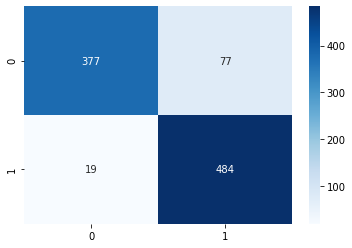

In [27]:
sn.heatmap(cm, annot=True, cmap="Blues", fmt='d')
plt.show()

In [28]:
print(classification_report(np.argmax(y_test, axis=-1),
                            np.argmax(y_pred, axis=-1),
                            target_names=["Begnin", "Malignant"]))

              precision    recall  f1-score   support

      Begnin       0.95      0.83      0.89       454
   Malignant       0.86      0.96      0.91       503

    accuracy                           0.90       957
   macro avg       0.91      0.90      0.90       957
weighted avg       0.91      0.90      0.90       957



In [29]:
model.save(MODEL_NAME)


INFO:tensorflow:Assets written to: efficientnet_b0_v2/assets
